In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
import gensim.downloader as api
from sklearn.metrics import f1_score
import numpy as np
from gensim.models import KeyedVectors
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.utils import tf_utils
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam
import keras.backend as K
import keras.layers as L
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_addons.text import crf_log_likelihood, crf_decode
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import accuracy_score



# Loading Test Datasets

In [5]:


with open('Json Task1/NER_test.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/ATE_test.json', 'r') as f:
    task2_test_data = json.load(f)

with open('glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)
    
with open('fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

with open('word2vec_embeddings.pkl', 'rb') as pickle_file:
    word2vec_embeddings = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}
bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

f1_mapping = {
    0: 'ORG',
    1: 'ORG',
    2: 'RESPONDENT',
    3: 'RESPONDENT',
    4: 'JUDGE',
    5: 'JUDGE',
    6: 'STATUTE',
    7: 'STATUTE',
    8: 'OTHER_PERSON',
    9: 'OTHER_PERSON',
    10: 'COURT',
    11: 'COURT',
    12: 'GPE',
    13: 'GPE',
    14: 'PETITIONER',
    15: 'PETITIONER',
    16: 'WITNESS',
    17: 'WITNESS',
    18: 'CASE_NUMBER',
    19: 'CASE_NUMBER',
    20: 'PRECEDENT',
    21: 'PRECEDENT',
    22: 'DATE',
    23: 'DATE',
    24: 'PROVISION',
    25: 'PROVISION',
    26: 'O'
}



# Padding the data

In [6]:
def pad_data():
    max_length = 84
    pad_word = 'PAD'

    data = [task1_test_data, task2_test_data]
    for task_data in data:
        remove_keys = []
        for key in task_data:
            words = task_data[key]['text'].split(' ')
            tags = task_data[key]['labels']
            if(len(words) >= max_length):
                remove_keys.append(key)
                continue
            else:
                for _ in range(len(words), max_length):
                    words.append(pad_word)
                    tags.append('O')   
            task_data[key]['text'] = ' '.join(words)
            task_data[key]['labels'] = tags
        
        for key in remove_keys:
            task_data.pop(key, None)



pad_data()

task1_test_data = {new_key: task1_test_data[old_key] for new_key, (old_key, _) in enumerate(task1_test_data.items())}

task2_test_data = {new_key: task2_test_data[old_key] for new_key, (old_key, _) in enumerate(task2_test_data.items())}



# Creating RNN, LSTM AND GRU Models

In [7]:
class RNNModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, 32, num_layers=1, batch_first=True)
        # self.fc1 = nn.Linear(128, 64)
        self.fc1 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.rnn(x)
        out = self.fc1(out)
        return out
    
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(LSTMModel, self).__init__()
        # self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, 32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.lstm(x)
        out = self.fc1(out)
        return out
    

class GRUModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(GRUModel, self).__init__()
        # self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.gru = nn.GRU(embedding_dim, 32, num_layers=1, batch_first=True)
        # self.fc1 = nn.Linear(128, 64)
        self.fc1 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.gru(x)
        out = self.fc1(out)
        # out = self.fc2(out)
        return out
class Task_data(Dataset):
    def __init__(self, data, bio_index, embedding_type):
        self.data = data
        self.length = len(self.data)
        self.bio_index =  bio_index
        self.embedding_type = embedding_type

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        input_sequence = self.data[index]['text'].split(' ')
        sentence_embeddings = []
        if self.embedding_type == "glove":
            sentence_embeddings = [glove_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "word2vec":
            sentence_embeddings = [word2vec_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "fast_text":
            sentence_embeddings = [np.array(fast_text_embedding.get(word, np.zeros(300, dtype = 'float32')), dtype = 'float32') for word in input_sequence]

        sentence_embeddings = np.array(sentence_embeddings, dtype='float32')
        output_sequence = self.data[index]['labels']
        output_labels = [self.bio_index[word] for word in output_sequence]

        # output_labels = np.array(output_labels, dtype='float32')
        return torch.tensor(sentence_embeddings), torch.tensor(output_labels)

# Generating Mappings

In [8]:
word_to_index_w2v = {}
ind = 0
word2vec_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in word2vec_embeddings.keys():
  word_to_index_w2v[word] = ind
  ind = ind + 1

vocab_size_w2v = len(word_to_index_w2v)

word_to_index_glove = {}
ind = 0
glove_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in glove_embeddings.keys():
  word_to_index_glove[word] = ind
  ind = ind + 1

vocab_size_glove = len(word_to_index_glove)
word_to_index_fasttext = {}
ind = 0
fast_text_embedding['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in fast_text_embedding.keys():
  word_to_index_fasttext[word] = ind
  ind = ind + 1

vocab_size_fasttext = len(word_to_index_fasttext)
# max_seq_len = 84

# CRF Layer

In [9]:
class CRF(L.Layer):

    def __init__(self, output_dim, **kwargs):

        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.transitions = None

    def build(self, input_shape):
        self.transitions = self.add_weight(name = 'transitions', shape=[self.output_dim, self.output_dim],
                                           initializer = 'glorot_uniform', trainable = True)

    def call(self, inputs, sequence_lengths = None, training = None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype = self.dtype)
        if sequence_lengths is not None:
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype = tf.int32) * tf.shape(inputs)[1]

        viterbi_sequence, _ = crf_decode(sequences, self.transitions, self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            log_likelihood, self.transitions = crf_log_likelihood(y_pred,
                                                                  tf.cast(K.argmax(y_true), dtype=tf.int32),
                                                                  self.sequence_lengths,
                                                                  transition_params=self.transitions)
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            mask = K.cast(K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * shape[1]
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

# Testing Function

In [10]:

def test_model(task, embedding_type, model, criterion, device, batch_size=1):
    test_dataloader = None
    if task == 1:
        test_dataloader = DataLoader(Task_data(task1_test_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=False)
    elif task == 2:
        test_dataloader = DataLoader(Task_data(task2_test_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=False)

    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            test_outputs = model(test_inputs)

            loss = 0
            for i in range(test_outputs.size(1)):  # Iterate over time steps
                loss += criterion(test_outputs[:, i, :], test_targets[:, i])  

            total_test_loss += loss.item()

            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_targets.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='macro')
        test_accuracy = accuracy_score(all_test_targets, all_test_predictions)
        
    print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}, Test Accuracy: {test_accuracy}')

# Processing function for model-4

In [11]:
def process_data(dataset,task, embedding_type):
    sentences = []
    labels = []
    max_length_train_1 = 80
    max_length_train_2 = 84
    # max_length_test_1 = 52
    # max_length_test_2 = 71
    bio_mapping_ = 0
    max_seq_len_ = 0
    if task == 1:
        bio_mapping_ = bio_mapping_task1
        max_seq_len_ = max_length_train_1
    else:
        bio_mapping_ = bio_mapping_task2
        max_seq_len_ = max_length_train_2
    # print(max_seq_len_)

# choosing embedding type
    if embedding_type == "word2vec":
        word_to_index = word_to_index_w2v

    if embedding_type == "glove":
        word_to_index = word_to_index_glove

    else:
        word_to_index = word_to_index_fasttext

    for index in dataset.keys():

        dic = dataset[index]
        tags = [bio_mapping_[label] for label in dic['labels']]
        sentence = dic['text'].split(' ')
        sequence = []
        for word in sentence:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(word_to_index['<unk>'])
        # print(len(sequence))
        if(len(sequence) >= max_seq_len_):
            continue

        if(len(sequence) < max_seq_len_):
            for i in range(len(sequence), max_seq_len_):
                sequence.append(word_to_index['<unk>'])
                tags.append(bio_mapping_['O'])
                # tags.append(3)

        sentences.append(sequence)
        labels.append(tags)

    tag_size = len(bio_mapping_)
    # print(tag_size)
    labels = [to_categorical(i, num_classes = tag_size) for i in labels]
    # print(len(labels), len(sentences))
    
    return np.array(sentences), np.asarray(labels)

# Creating Bilstm-Crf models

In [12]:
def build_1(vocab_size, word_index, emb_type):
    if emb_type == "word2vec":
        embeddings_index = word2vec_embeddings

    elif emb_type == "glove":
        embeddings_index = glove_embeddings
    else:
        embeddings_index = fast_text_embedding

    embeddings_index = {}
    embeddings_matrix = np.zeros((vocab_size, 300))

    for word, i in word_index.items():
        if i > vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length = 80, weights = [embeddings_matrix], mask_zero = True))
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.01)))
    model.add(Bidirectional(LSTM(units = 30, return_sequences = True, recurrent_dropout = 0.15)))
    model.add(TimeDistributed(Dense(27)))
    crf = CRF(27)
    model.add(crf)
    return model



def build_2(vocab_size, word_index, emb_type):

    if emb_type == "word2vec":
        embeddings_index = word2vec_embeddings

    elif emb_type == "glove":
        embeddings_index = glove_embeddings
    else:
        embeddings_index = fast_text_embedding

    embeddings_index = {}
    embeddings_matrix = np.zeros((vocab_size,300))

    for word, i in word_index.items():
        if i > vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length = 84, weights = [embeddings_matrix], mask_zero = True))
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.05)))
    model.add(Bidirectional(LSTM(units = 32, return_sequences = True, recurrent_dropout = 0.15)))
    model.add(TimeDistributed(Dense(3)))
    crf = CRF(3)
    model.add(crf)
    return model

def calculate_f1_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_argmax = np.argmax(y_pred, axis=-1)
    y_true_argmax = np.argmax(y_test, axis=-1)
    f1 = f1_score(y_true_argmax.flatten(), y_pred_argmax.flatten(), average = 'macro')
    return f1

In [13]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Testing RNN Models

In [14]:
task_ = 1
t1_rnn_word2vec = torch.load('trained_models/t1_model1_word2vec.pt')
print("t1_rnn_word2vec")
test_model(task = task_, embedding_type = "word2vec", model = t1_rnn_word2vec, criterion=criterion, device=device)
print("t1_rnn_glove")
t1_rnn_glove = torch.load('trained_models/t1_model1_glove.pt')
test_model(task = task_, embedding_type = "glove", model = t1_rnn_glove, criterion=criterion, device=device)
print("t1_rnn_fast_text")
t1_rnn_fast_text = torch.load('trained_models/t1_model1_fast_text.pt')
test_model(task = task_, embedding_type = "fast_text", model = t1_rnn_fast_text, criterion=criterion, device=device)

task_ = 2
t2_rnn_word2vec = torch.load('trained_models/t2_model1_word2vec.pt')
print("t2_rnn_word2vec")
test_model(task = task_, embedding_type = "word2vec", model = t2_rnn_word2vec, criterion=criterion, device=device)
t2_rnn_glove  = torch.load('trained_models/t2_model1_glove.pt')
print("t2_rnn_glove")
test_model(task = task_, embedding_type = "glove", model = t2_rnn_glove, criterion=criterion, device=device)
t2_rnn_fast_text = torch.load('trained_models/t2_model1_fast_text.pt')
print("t2_rnn_fast_text")
test_model(task = task_, embedding_type = "fast_text", model = t2_rnn_fast_text, criterion=criterion, device=device)

t1_rnn_word2vec
Test Loss: 11.740047338547365, Test Macro F1-Score: 0.388980559944608, Test Accuracy: 0.9648686460438365
t1_rnn_glove
Test Loss: 10.376716428062391, Test Macro F1-Score: 0.41710771184468665, Test Accuracy: 0.9686771335302348
t1_rnn_fast_text
Test Loss: 9.752915718593716, Test Macro F1-Score: 0.3948508353035882, Test Accuracy: 0.9684698689051247
t2_rnn_word2vec
Test Loss: 6.679583282732382, Test Macro F1-Score: 0.49412518400934524, Test Accuracy: 0.9773519163763066
t2_rnn_glove
Test Loss: 5.92492855176693, Test Macro F1-Score: 0.49614033381035155, Test Accuracy: 0.9773882113821138
t2_rnn_fast_text
Test Loss: 6.40417336618028, Test Macro F1-Score: 0.38904428761369086, Test Accuracy: 0.975246806039489


# Testing LSTM Models

In [15]:
task_ = 1
print("task1_lstm_word2vec")
task1_lstm_word2vec = torch.load('trained_models/t1_model2_word2vec.pt')
test_model(task = task_, embedding_type = "word2vec", model = task1_lstm_word2vec, criterion=criterion, device=device)
print("task1_lstm_glove")
task1_lstm_glove = torch.load('trained_models/t1_model2_glove.pt')
test_model(task = task_, embedding_type = "glove", model = task1_lstm_glove, criterion=criterion, device=device)
print("task1_lstm_fast_text")
task1_lstm_fast_text = torch.load('trained_models/t1_model2_fast_text.pt')
test_model(task = task_, embedding_type = "fast_text", model = task1_lstm_fast_text, criterion=criterion, device=device)

task_ = 2
print("task2_lstm_word2vec")
task2_lstm_word2vec = torch.load('trained_models/t2_model2_word2vec.pt')
test_model(task = task_, embedding_type = "word2vec", model = task2_lstm_word2vec, criterion=criterion, device=device)
print("task2_lstm_glove")
task2_lstm_glove = torch.load('trained_models/t2_model2_glove.pt')
test_model(task = task_, embedding_type = "glove", model = task2_lstm_glove, criterion=criterion, device=device)
print("task2_lstm_fast_text")
task2_lstm_fast_text = torch.load('trained_models/t2_model2_fast_text.pt')
test_model(task = task_, embedding_type = "fast_text", model = task2_lstm_fast_text, criterion=criterion, device=device)

task1_lstm_word2vec
Test Loss: 12.965984447801464, Test Macro F1-Score: 0.44395642899718474, Test Accuracy: 0.9642857142857143
task1_lstm_glove
Test Loss: 11.591764899088785, Test Macro F1-Score: 0.48691259136665765, Test Accuracy: 0.9687937198818591
task1_lstm_fast_text
Test Loss: 8.583206160344139, Test Macro F1-Score: 0.45014480664312484, Test Accuracy: 0.9715529302036375
task2_lstm_word2vec
Test Loss: 4.085268241058036, Test Macro F1-Score: 0.6393910482986204, Test Accuracy: 0.9819613821138211
task2_lstm_glove
Test Loss: 3.83084511884102, Test Macro F1-Score: 0.5835704061603947, Test Accuracy: 0.9825058072009292
task2_lstm_fast_text
Test Loss: 5.099730147094261, Test Macro F1-Score: 0.39782553143656035, Test Accuracy: 0.9745572009291521


# Testing GRU Models

In [16]:
task_ = 1
print("task1_gru_word2vec")
task1_gru_word2vec = torch.load('trained_models/t1_model3_word2vec.pt')
test_model(task = task_, embedding_type = "word2vec", model = task1_gru_word2vec, criterion=criterion, device=device)
print("task1_gru_glove")
task1_gru_glove = torch.load('trained_models/t1_model3_glove.pt')
test_model(task = task_, embedding_type = "glove", model = task1_gru_glove, criterion=criterion, device=device)
print("task1_gru_fast_text")
task1_gru_fast_text = torch.load('trained_models/t1_model3_fast_text.pt')
test_model(task = task_, embedding_type = "fast_text", model = task1_gru_fast_text, criterion=criterion, device=device)

task_ = 2
print("task2_gru_word2vec")
task2_gru_word2vec = torch.load('trained_models/t2_model3_word2vec.pt')
test_model(task = task_, embedding_type = "word2vec", model = task2_gru_word2vec, criterion=criterion, device=device)
print("task2_gru_glove")
task2_gru_glove = torch.load('trained_models/t2_model3_glove.pt')
test_model(task = task_, embedding_type = "glove", model = task2_gru_glove, criterion=criterion, device=device)
print("task2_gru_fast_text")
task2_gru_fast_text = torch.load('trained_models/t2_model3_fast_text.pt')
test_model(task = task_, embedding_type = "fast_text", model = task2_gru_fast_text, criterion=criterion, device=device)

task1_gru_word2vec
Test Loss: 11.772546144458744, Test Macro F1-Score: 0.44316043606860306, Test Accuracy: 0.9649593243173221
task1_gru_glove
Test Loss: 10.935374668804407, Test Macro F1-Score: 0.4732700735687208, Test Accuracy: 0.9686771335302348
task1_gru_fast_text
Test Loss: 8.591720511924, Test Macro F1-Score: 0.4751370632763503, Test Accuracy: 0.9717083786724701
task2_gru_word2vec
Test Loss: 4.1824229497735095, Test Macro F1-Score: 0.6403280405564583, Test Accuracy: 0.982832462253194
task2_gru_glove
Test Loss: 5.716632490114468, Test Macro F1-Score: 0.46937512168078505, Test Accuracy: 0.9762993612078978
task2_gru_fast_text
Test Loss: 3.9069089361625475, Test Macro F1-Score: 0.6614762842504465, Test Accuracy: 0.9825058072009292


In [17]:
with open('Json Task1/NER_test.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/ATE_test.json', 'r') as f:
    task2_test_data = json.load(f)

# Testing Bilstm-Crf Models (Task-1)

In [18]:
type_embedding = "word2vec"
# bio_mapping = bio_mapping_task1
word_index = word_to_index_w2v
vocab = vocab_size_w2v
model = build_1(vocab_size = vocab,  word_index = word_index,  emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t1_bilstm-crf_word2vec")
X_test, y_test = process_data(task1_test_data, 1, type_embedding)
model.load_weights("trained_models/t1_model4_word2vec.h5")
# print(X_test.shape, y_test.shape)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

type_embedding = "glove"
word_index = word_to_index_glove
vocab = vocab_size_glove
model = build_1(vocab_size = vocab,  word_index = word_index,  emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t1_bilstm-crf_glove")
X_test, y_test = process_data(task1_test_data, 1, type_embedding)
model.load_weights("trained_models/t1_model4_glove.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

type_embedding = "fast_text"
word_index = word_to_index_fasttext
vocab = vocab_size_fasttext
model = build_1(vocab_size = vocab,  word_index = word_index,  emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t1_bilstm-crf_fast_text")
X_test, y_test = process_data(task1_test_data, 1, type_embedding)
model.load_weights("trained_models/t1_model4_fast_text.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')


t1_bilstm-crf_word2vec
29/29 [==============================] - 2s 48ms/step
Test Loss: 111.62844848632812 - Test Accuracy: 0.9685660600662231 - Test F1 Score: 0.5514024304932523
t1_bilstm-crf_glove
29/29 [==============================] - 2s 53ms/step
Test Loss: 106.52397155761719 - Test Accuracy: 0.9714785218238831 - Test F1 Score: 0.6093309812621077
t1_bilstm-crf_fast_text
29/29 [==============================] - 2s 49ms/step
Test Loss: 115.49148559570312 - Test Accuracy: 0.9704295992851257 - Test F1 Score: 0.5676456309931004


# Testing Bilstm-Crf Models (Task-2)

In [19]:
type_embedding = "word2vec"
# bio_mapping = bio_mapping_task2
word_index = word_to_index_w2v
vocab = vocab_size_w2v
model = build_2(vocab_size = vocab, word_index = word_index, emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t2_bilstm-crf_word2vec")
X_test, y_test = process_data(task2_test_data, 2, type_embedding)
model.load_weights("trained_models/t2_model4_word2vec.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

type_embedding = "glove"
word_index = word_to_index_glove
vocab = vocab_size_glove
model = build_2(vocab_size = vocab,  word_index = word_index, emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t2_bilstm-crf_glove")
X_test, y_test = process_data(task2_test_data, 2, type_embedding)
model.load_weights("trained_models/t2_model4_glove.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

type_embedding = "fast_text"
word_index = word_to_index_fasttext
vocab = vocab_size_fasttext
model = build_2(vocab_size = vocab, word_index = word_index,  emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

print("t2_bilstm-crf_fast_text")
X_test, y_test = process_data(task2_test_data, 2, type_embedding)
model.load_weights("trained_models/t2_model4_fasttext.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')


t2_bilstm-crf_word2vec
11/11 [==============================] - 1s 47ms/step
Test Loss: 40.65141296386719 - Test Accuracy: 0.9753448963165283 - Test F1 Score: 0.7282399152304673
t2_bilstm-crf_glove
11/11 [==============================] - 1s 46ms/step
Test Loss: 43.3255729675293 - Test Accuracy: 0.9775095582008362 - Test F1 Score: 0.7281494689941642
t2_bilstm-crf_fast_text
11/11 [==============================] - 1s 62ms/step
Test Loss: 37.74606704711914 - Test Accuracy: 0.9840368628501892 - Test F1 Score: 0.7290006567438176


# Task-1 F1-Plot

In [20]:
type_embedding = "glove"
word_index = word_to_index_glove
vocab = vocab_size_glove
model = build_1(vocab_size = vocab,  word_index = word_index,  emb_type = type_embedding)
model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

X_test, y_test = process_data(task1_test_data, 1, type_embedding)
model.load_weights("trained_models/t1_model4_glove.h5")
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=-1).flatten()
y_true_argmax = np.argmax(y_test, axis=-1).flatten()

y_true_labels = [f1_mapping[label] for label in y_true_argmax]
y_pred_labels = [f1_mapping[label] for label in y_pred_argmax]



29/29 [==============================] - 2s 53ms/step


In [21]:
a = classification_report(y_true_labels, y_pred_labels)
print(a)


              precision    recall  f1-score   support

 CASE_NUMBER       0.65      0.63      0.64       335
       COURT       0.90      0.81      0.85       463
        DATE       0.83      0.69      0.76       311
         GPE       0.45      0.45      0.45       216
       JUDGE       0.67      0.67      0.67        15
           O       0.99      0.99      0.99     68335
         ORG       0.48      0.41      0.44       405
OTHER_PERSON       0.80      0.51      0.62       436
  PETITIONER       0.40      0.47      0.43        17
   PRECEDENT       0.93      0.91      0.92      1636
   PROVISION       0.96      0.90      0.93       686
  RESPONDENT       0.00      0.00      0.00        11
     STATUTE       0.78      0.86      0.82       554
     WITNESS       0.71      0.46      0.56       100

    accuracy                           0.98     73520
   macro avg       0.68      0.63      0.65     73520
weighted avg       0.98      0.98      0.98     73520



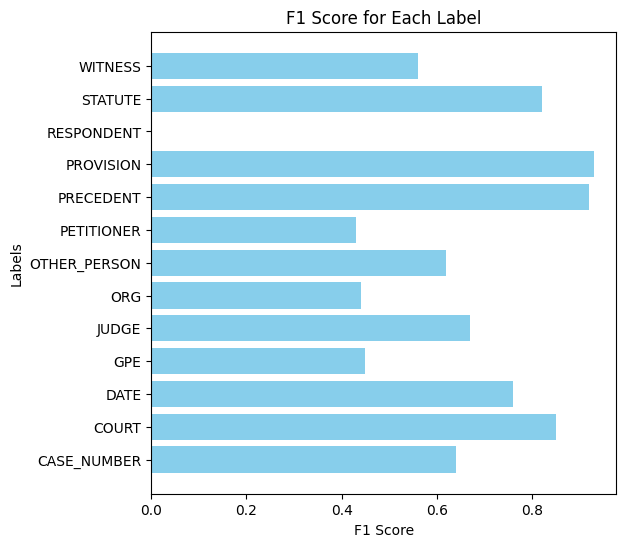

In [22]:
labels = ['CASE_NUMBER', 'COURT', 'DATE', 'GPE', 'JUDGE', 'ORG', 'OTHER_PERSON', 'PETITIONER',
          'PRECEDENT', 'PROVISION', 'RESPONDENT', 'STATUTE', 'WITNESS']

f1_scores = [0.64, 0.85, 0.76, 0.45, 0.67, 0.44, 0.62, 0.43, 0.92, 0.93, 0.00, 0.82, 0.56]

# Plotting
plt.figure(figsize=(6, 6))
plt.barh(labels, f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.ylabel('Labels')
plt.title('F1 Score for Each Label')
# plt.xlim(0, 1)  
plt.show()

